# Lesson 02
# Peter Lorenz

## 0. Preliminaries

First import the required libraries:

In [34]:
from imblearn.over_sampling import SMOTE 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Set some global options:

In [44]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Read Data

Next import the data set:

In [66]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Intrusion%20Detection.csv"

# Download the data into a dataframe object
intrusion_data = pd.read_csv(url)

# Display data
intrusion_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.000,0.000,0.110,0.000,0.000,0.000,0.000,0.000,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.000,0.000,0.030,0.000,0.000,0.000,0.000,0.000,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.000,0.000,0.030,0.000,0.000,0.000,0.000,0.000,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.000,0.000,0.020,0.000,0.000,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97303,321,tcp,telnet,RSTO,1506,1887,0,0,0,0,...,6,1.000,0.000,0.170,0.000,0.000,0.000,0.170,0.170,1
97304,45,tcp,telnet,SF,2336,4201,0,0,0,3,...,7,1.000,0.000,0.140,0.000,0.000,0.000,0.140,0.140,1
97305,176,tcp,telnet,SF,1559,2732,0,0,0,3,...,8,1.000,0.000,0.120,0.000,0.000,0.000,0.120,0.120,1
97306,61,tcp,telnet,SF,2336,4194,0,0,0,3,...,9,1.000,0.000,0.110,0.000,0.000,0.000,0.110,0.110,1


## 2. Build a Classifier

Now we build the classifier.

### Data Cleaning

First we have to encode the categorical variables as dummy variables. There are three categorical variables: *protocol_type*, *service*, and *flag*, which we encode using pandas:

In [67]:
# Use pandas to one-hot encode categorical variables as k-1 dummies per column
intrusion_data_enc = pd.get_dummies(intrusion_data, columns=["protocol_type", "service", "flag"], drop_first=True)

# List column names
list(intrusion_data_enc)

['duration',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Class',
 'protocol_type_tcp',
 'protocol_type_udp',
 'service_X11',
 'service_auth',
 'service_domain',
 'service_domain_u',
 'service_eco_i',
 'service_ecr_i',
 'service_finger',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_ntp_u',
 'service_other'

### Training / Test Split

To determine a suitable training / test split we consider the size of the data set:

In [68]:
intrusion_data_enc["duration"].count()

97308

Given the size of the data set (97, 308 rows) we would prefer to set aside just a small percentage of the data for the test data set. But we should also consider the number of identified positives (i.e. intrusions) in the total data set, since we require at least some positives in our test data set:

In [77]:
print("Intrusions:       " + str(np.size(np.where(intrusion_data_enc["Class"] == 1))))
print("Non-intrusions:   " + str(np.size(np.where(intrusion_data_enc["Class"] == 0))))

Intrusions:       30
Non-intrusions:   97278


Given that we have only 30 identified positives (i.e. intrusions) and we require some positives in our test data set, the percentage of test data cannot be too small. Therefore, we select a training / test split of 90% to 10%. This will place 9731 rows in our test data. Since intrusions occur at a rate of one in 3161, we can expect roughly 3 intrusions to appear in the test data.

We now split the data into training and test and build the model:

In [29]:
# Extract label column
label_col = intrusion_data_enc["Class"]

# Reference remaining columns
model_data = intrusion_data_enc.drop(["Class"], axis=1)

# Partition into test and training with 10% test and 90% training
x_train, x_test, y_train, y_test = train_test_split(model_data, 
                                                    label_col, 
                                                    test_size = 0.1, 
                                                    random_state = 0)

# Build model and predict
clf = LogisticRegression().fit(x_train, y_train)
y_pred = clf.predict(x_test)

## 3. Determine Model Accuracy

Next we assess the accuracy of our model. Given the sparsity of positives in the data set, the accuracy score is unsurprisingly off the charts:

In [30]:
accuracy_score(y_test, y_pred)

0.9998972356386805

The accuracy score is high because simply predicting that there are no intrusions would be correct nearly always. The trouble is that the tiny fraction of malicious connections that do occur is so potentially costly that we cannot afford simply to ignore it because it is small.

To get a better sense of our model performance we examine the confusion matrix and the precision and recall metrics. First consider the confusion matrix:

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

Then consider precision and recall:

In [31]:
print(classification_report(y_test, y_pred))

[[9729    0]
 [   1    1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9729
           1       1.00      0.50      0.67         2

    accuracy                           1.00      9731
   macro avg       1.00      0.75      0.83      9731
weighted avg       1.00      1.00      1.00      9731



In the above model, one intrusion was correctly identified as an intrusion, but one actual intrusion was misclassified as a benign connection. This is reflected in the *recall* score of 0.5 (i.e. half of the actual positives were identified as such). Because there were no false positives, the *precision* is 1.0. But this is nothing impressive given the sparsity of actual positives in the data set.

These results are reinforced by the ROC curve, which reveals a substantial proportion of misses of true positives:

Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0, 1)

(0, 1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

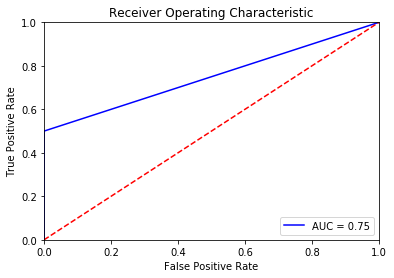

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In the final analysis, we cannot accept this model because the single intrusion that escaped detection could be the one that brings down our whole business.

## 4. Modify Data by Handling Class Imbalance

To address problems caused by the sparse occurrence of positives, one strategy is to modify the initial data set to balance out the classes.

In [62]:
# Instantiate SMOTE reference
sm = SMOTE(random_state=1)

# Apply oversampling to model data and label column
X_resample, y_resample = sm.fit_resample(model_data, label_col)

# Convert resampled model data to dataframe
df_resample = pd.DataFrame(X_resample, columns=model_data.columns)

Let's see how many rows are now in the data set:

In [63]:
df_resample["duration"].count()

194556

That nearly doubles the rows in our initial data set. Let's also check how many rows are labeled as intrusions in the resample:

In [75]:
print("Intrusions:     " + str(np.size(np.where(y_resample == 1))))
print("Non-intrusions: " + str(np.size(np.where(y_resample == 0))))

Intrusions:     97278
Non-intrusions: 97278


On the other hand, the number of rows classed as intrusions has gone from 30 to 97,278! Meanwhile, the number of rows classed as benign remains at 97,278. So the two classes are now equally represented.

## 5. Use Same Model on Updated Data

Now we reapply our model using the balanced data set. Because the classes are balanced, we can optimize the training / test split to 99% to 1% in order to apply more data to training the model:

In [79]:
# Partition into test and training with 1% test and 99% training
x_train_res, x_test_res, y_train_res, y_test_res = train_test_split(df_resample, 
                                                                    y_resample, 
                                                                    test_size = 0.01, 
                                                                    random_state = 0)

# Build model and predict
clf_res = LogisticRegression().fit(x_train_res, y_train_res)
y_pred_res = clf_res.predict(x_test_res)

## 6. What Is the Accuracy?

Next we verify the accuracy of the new model:

In [80]:
accuracy_score(y_test_res, y_pred_res)

0.9948612538540597

The accuracy is still quite high, though not as high as for the old imbalanced model. But the real test is the confusion matrix and precision and recall metrics. Here is the confusion matrix:

In [81]:
cm_res = metrics.confusion_matrix(y_test_res, y_pred_res)
print(cm_res)

[[965  10]
 [  0 971]]


This confusion matrix looks more promising. Let's also examine the precision and recall:

In [82]:
print(classification_report(y_test_res, y_pred_res))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       975
           1       0.99      1.00      0.99       971

    accuracy                           0.99      1946
   macro avg       0.99      0.99      0.99      1946
weighted avg       0.99      0.99      0.99      1946



Finally we are close to a working model! The model has not missed a single intrusion, hence, the recall of 1.0. The precision of 0.99 means that some benign connections are mistakenly flagged as intrusions. While this is no doubt inconvenient for certain legitimate users, it is definitely preferable to having an undetected intrusion wreaking potential havoc with our business.

This is confirmed by the ROC curve:

Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0, 1)

(0, 1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

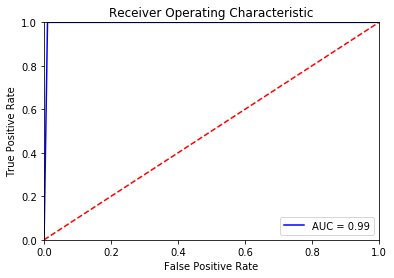

In [83]:
fpr_res, tpr_res, thresholds_res = metrics.roc_curve(y_test_res, y_pred_res)
roc_auc_res = metrics.auc(fpr_res, tpr_res)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_res, tpr_res, 'b', label = 'AUC = %0.2f' % roc_auc_res)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve reveals a model

## Describe Findings

TODO